# Unsupervised learning

In [1]:
from brian2 import *

## Origin AdEx

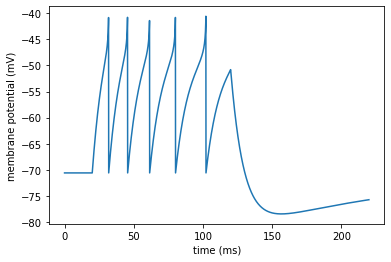

In [6]:
start_scope()

# Parameters
C = 281 * pF
gL = 30 * nS
taum = C / gL
EL = -70.6 * mV
VT = -50.4 * mV
DeltaT = 2 * mV
Vcut = VT + 5 * DeltaT

# Pick an electrophysiological behaviour
tauw, a, b, Vr = 144*ms, 4*nS, 0.0805*nA, -70.6*mV # Regular spiking (as in the paper)
#tauw,a,b,Vr=20*ms,4*nS,0.5*nA,VT+5*mV # Bursting
#tauw,a,b,Vr=144*ms,2*C/(144*ms),0*nA,-70.6*mV # Fast spiking

eqs = """
dvm/dt = (gL*(EL - vm) + gL*DeltaT*exp((vm - VT)/DeltaT) + I - w)/C : volt
dw/dt = (a*(vm - EL) - w)/tauw : amp
I : amp
"""

neuron = NeuronGroup(1, model=eqs, threshold='vm>Vcut',
                     reset="vm=Vr; w+=b", method='euler')
neuron.vm = EL
trace = StateMonitor(neuron, 'vm', record=0)
spikes = SpikeMonitor(neuron)

run(20 * ms)
neuron.I = 1*nA
run(100 * ms)
neuron.I = 0*nA
run(100 * ms)

# # We draw nicer spikes
# vm = trace[0].vm[:]
# for t in spikes.t:
#     i = int(t / defaultclock.dt)
#     vm[i] = 20*mV

plot(trace.t / ms, trace[0].vm / mV)
xlabel('time (ms)')
ylabel('membrane potential (mV)')
show()

## Modified AdEx

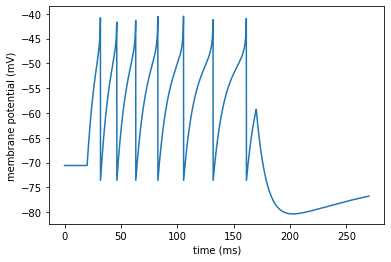

In [14]:
start_scope()

# Parameters
C = 281 * pF
gL = 30 * nS
taum = C / gL
EL = -70.6 * mV
VT = -50.4 * mV
DeltaT = 2 * mV
Vcut = VT + 5 * DeltaT
Tr = 1 * ms

# Pick an electrophysiological behaviour
tauw, a, b, Vr = 144*ms, 4*nS, 0.0805*nA, EL - 3 * mV # Regular spiking (as in the paper)
#tauw,a,b,Vr=20*ms,4*nS,0.5*nA,VT+5*mV # Bursting
#tauw,a,b,Vr=144*ms,2*C/(144*ms),0*nA,-70.6*mV # Fast spiking

eqs = """
dvm/dt = (gL*(EL - vm) + gL*DeltaT*exp((vm - VT)/DeltaT) + I - w)/C : volt (unless refractory)
dw/dt = (a*(vm - EL) - w)/tauw : amp
I : amp
"""

neuron = NeuronGroup(
    1, model=eqs, threshold='vm>Vcut',
    reset="vm=Vr; w+=b", 
    refractory=Tr,
    method='euler'
)
neuron.vm = EL
trace = StateMonitor(neuron, 'vm', record=0)
spikes = SpikeMonitor(neuron)

run(20 * ms)
neuron.I = 1*nA
run(150 * ms)
neuron.I = 0*nA
run(100 * ms)

plot(trace.t / ms, trace[0].vm / mV)
xlabel('time (ms)')
ylabel('membrane potential (mV)')
show()

### add input

In [2]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(np.zeros(Ns), np.arange(Ns), 'ok', ms=10)
    plot(np.ones(Nt), np.arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

In [40]:
input_patterns = np.array([
    [[0., 1.],
     [1., 0.]],
    [[1., 0.],
     [0., 1.]],
])
n_patterns = input_patterns.shape[0]
input_patterns = input_patterns.reshape((n_patterns, -1))

poisson_params = 80, 1.

# stimulus = TimedArray(np.tile([100., 0.], 5)*Hz, dt=100.*ms)
# P = PoissonGroup(1, rates='stimulus(t)')

poisson_rates = input_patterns * np.random.normal(poisson_params[0], poisson_params[1], size=input_patterns.shape)
poisson_rates

array([[ 0.        , 79.77856444, 80.71724675,  0.        ],
       [80.11112178,  0.        ,  0.        , 81.43047607]])

In [91]:
start_scope()

# Parameters
N = 3
C = 281 * pF
gL = 30 * nS
taum = C / gL
EL = -70.6 * mV
VT = -50.4 * mV
DeltaT = 2 * mV
Vcut = VT + 5 * DeltaT
Tr = 5 * ms
I_tonic = 0.1 * .6 * nA

# Pick an electrophysiological behaviour
tauw, a, b, Vr = 144*ms, 4*nS, 0.0805*nA, EL - 3 * mV # Regular spiking (as in the paper)
#tauw,a,b,Vr=20*ms,4*nS,0.5*nA,VT+5*mV # Bursting
#tauw,a,b,Vr=144*ms,2*C/(144*ms),0*nA,-70.6*mV # Fast spiking

eqs = """
dvm/dt = (gL*(EL - vm) + gL*DeltaT*exp((vm - VT)/DeltaT) + I - w + 0*xi*0.2*nA*ms**.5)/C : volt
dw/dt = (a*(vm - EL) - w)/tauw : amp
I : amp
"""

n_tile = 50
change_time = 200
stimulus = TimedArray(
    np.tile(poisson_rates, (n_tile, 1)) * Hz,
    dt=change_time * ms
)
inPG = PoissonGroup(input_patterns.shape[1], rates='stimulus(t, i)')

L1 = NeuronGroup(
    N, model=eqs, threshold='vm>Vcut',
    reset="vm=Vr; w+=b", 
    refractory=Tr,
    method='euler'
)
L1.vm = 'EL + rand()*5*mV'
L1.I = I_tonic

taupre = taupost = 20*ms
w_syn_max = 10.
Apre = 0.04 * w_syn_max
Apost = -Apre*taupre/taupost*1.05
inL = Synapses(
    inPG, L1, 
    '''
    w_syn : 1
    dapre/dt = -apre/taupre : 1 (clock-driven)
    dapost/dt = -apost/taupost : 1 (clock-driven)
    ''',    
    on_pre='''
    vm_post += w_syn * mV
    apre += Apre
    w_syn = clip(w_syn + apost, 0., w_syn_max)
    ''',
    on_post='''
    apost += Apost
    w_syn = clip(w_syn + apre, 0., w_syn_max)
    ''',
    method='linear'
)
inL.connect()
inL.w_syn = 'w_syn_max * rand()'
inL.delay = 0 * 2 * ms

ihL = Synapses(
    L1, L1, 
    '''
    w_syn : 1
    dapre/dt = -apre/taupre : 1 (clock-driven)
    dapost/dt = -apost/taupost : 1 (clock-driven)
    ''',    
    on_pre='''
    vm_post -= w_syn * mV
    apre += Apre
    w_syn = clip(w_syn + apost, 0., w_syn_max)
    ''',
    on_post='''
    apost += Apost
    w_syn = clip(w_syn + apre, 0., w_syn_max)
    ''',
    method='linear'
)
ihL.connect(condition='i!=j')
inL.w_syn = 'w_syn_max * rand()'
ihL.delay = 0 * 2 * ms

L1_trace = StateMonitor(L1, 'vm', record=True)
L1_spikes = SpikeMonitor(L1)
inL_trace = StateMonitor(inL, ['w_syn', 'apre', 'apost'], record=True)
ihL_trace = StateMonitor(ihL, ['w_syn', 'apre', 'apost'], record=True)

run_time = 4000
run(4000 * ms)

# print(inL.w_)
# print(ihL.w_)
# visualise_connectivity(ihL)

<spikemonitor.count_: array([10, 22,  0], dtype=int32)>


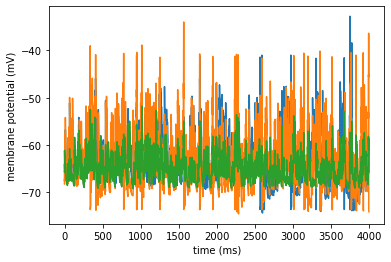

In [93]:
for k in range(3):
    plot(L1_trace.t / ms, L1_trace[k].vm / mV)
print(L1_spikes.count_)
xlabel('time (ms)')
ylabel('membrane potential (mV)')
show()

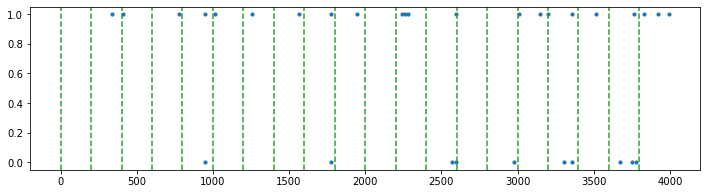

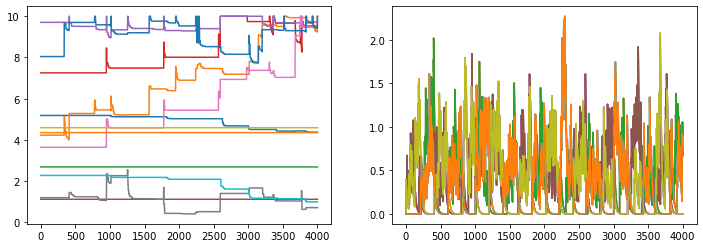

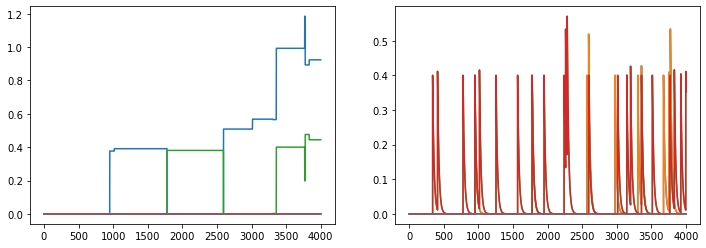

In [95]:
def plot_spikes(mon):
    figure(figsize=(12,3))
    scatter(mon.t/ms, mon.i, s=10)
    for t in range(0, run_time, change_time):
        axvline(t, ls='--', c='C2')
    
    show()

def plot_syn_layer(L, n):
    figure(figsize=(12,4))
    subplot(121)
    for k in range(n):
        plot(L.t/ms, L.w_syn[k])
    subplot(122)
    for k in range(n):
        plot(L.t/ms, L.apre[k])
    show()
    
plot_spikes(L1_spikes)
plot_syn_layer(inL_trace, 12)
plot_syn_layer(ihL_trace, 6)